identify domains in 3-component system using Voronoi edge method to determine neighbors and Lo/Ld

then, find area per lipid to compare Lo/Ld and R/AR

based off of interface code

mdw 05/05/2017


In [1]:
from __future__ import print_function
%matplotlib inline
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
#import scipy.cluster.hierarchy
import scipy.spatial

In [2]:
traj=md.load('POPE_POPS_CHOL_1us.gro',top='POPE_POPS_CHOL_1us.gro',stride=12000)

/Users/naveen/anaconda/lib/python2.7/site-packages/mdtraj/core/trajectory.py:417: UserWarning: top= kwarg ignored since file contains topology information
  warnings.warn('top= kwarg ignored since file contains topology information')


In [3]:
traj.n_frames

1

In [4]:
topology=traj.topology
allhead=topology.select('name PO4 or name ROH')

In [5]:
resnames=[atom.residue.name for atom in topology.atoms]

In [6]:
#x,y coordinates of all for finding neighbors to determine local midplane z-value
# here, best to use xy radius of neighbors, since Voronoi across 2 leaflets could have complications

allheadxy=list([] for _ in xrange(traj.n_frames))
allheadz=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    for i in range(len(allhead)):
        allheadi=allhead[i]
        allheadxy[nn].append(traj.xyz[nn][allheadi][0:2:1])
        allheadz[nn].append(traj.xyz[nn][allheadi][2])


In [7]:
# mdtraj can't handle neighbors for gro (rather than xtc) inputs, so do it myself
#cutoffsq = 2.4**2; #square of maximum xy distance for neighbors
cutoffsq=1.0**2
neigh=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    neigh[nn]=list([] for _ in xrange(len(allhead)))
    for i in range(len(allheadxy[nn])):
        xyi=allheadxy[nn][i]
        for j in range(len(allhead)-i-1): #not self, but will add for midplane finding
            xyj=allheadxy[nn][j+i+1]
            distsq=(xyi[0]-xyj[0])**2 + (xyi[1]-xyj[1])**2
            if (distsq < cutoffsq):
                neigh[nn][i].append(j+i+1)
                neigh[nn][j+i+1].append(i)
  

In [8]:
#new leaflet id method based on tilt angles; PO4-C4A or ROH-C1 (both +6 beads)
num_head=len(allhead)
tiltvectors=list([] for _ in xrange(traj.n_frames))

for nn in range(traj.n_frames):
    tiltvectors[nn]=list([] for _ in xrange(num_head)) #store vector roh-c1 or po4-c4a
    
    for i in range(num_head):
        tiltvectors[nn][i]=traj.xyz[nn][allhead[i]]-traj.xyz[nn][allhead[i]+6]


In [9]:
# must fix periodic boundary condition errors in tiltvectors, then calculate tiltangle
norms=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    norms[nn]=list([] for _ in xrange(len(allhead)))
    halfx=0.5*traj.unitcell_lengths[nn][0]
    halfy=0.5*traj.unitcell_lengths[nn][1]
    halfz=0.5*traj.unitcell_lengths[nn][2]
    for i in range(len(allhead)):
        norms[nn][i]=np.linalg.norm(tiltvectors[nn][i])
        if (norms[nn][i] > halfz):
            if (np.abs(tiltvectors[nn][i][0]) > halfx):
                if (tiltvectors[nn][i][0]>0): 
                    tiltvectors[nn][i][0]=tiltvectors[nn][i][0]-2*halfx
                else:
                    tiltvectors[nn][i][0]=tiltvectors[nn][i][0]+2*halfx
            if (np.abs(tiltvectors[nn][i][1]) > halfy):
                if (tiltvectors[nn][i][1]>0): 
                    tiltvectors[nn][i][1]=tiltvectors[nn][i][1]-2*halfy
                else:
                    tiltvectors[nn][i][1]=tiltvectors[nn][i][1]+2*halfy
            if (np.abs(tiltvectors[nn][i][2]) > halfz):
                if (tiltvectors[nn][i][2]>0): 
                    tiltvectors[nn][i][2]=tiltvectors[nn][i][2]-2*halfz
                else:
                    tiltvectors[nn][i][2]=tiltvectors[nn][i][2]+2*halfz

    for i in range(len(allhead)):
        norms[nn][i]=np.linalg.norm(tiltvectors[nn][i])


In [10]:
# use neigh to find local average tilt vector, outliers are not in a leaflet
# if pointing neg in z, flip in x,y,z for making average in outer leaflet
localvector=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    localvector[nn]=list([] for _ in xrange(len(allhead)))
    for i in range(len(allhead)):
        localvectorsx=[]
        localvectorsy=[]
        localvectorsz=[]
        sgn=np.sign(tiltvectors[nn][i][2])
        localvectorsx.append(sgn*tiltvectors[nn][i][0]) #include self
        localvectorsy.append(sgn*tiltvectors[nn][i][1]) #include self
        localvectorsz.append(sgn*tiltvectors[nn][i][2]) #include self
        for j in range(len(neigh[nn][i])):
            sgn=np.sign(tiltvectors[nn][neigh[nn][i][j]][2])
            localvectorsx.append(sgn*tiltvectors[nn][neigh[nn][i][j]][0])
            localvectorsy.append(sgn*tiltvectors[nn][neigh[nn][i][j]][1])
            localvectorsz.append(sgn*tiltvectors[nn][neigh[nn][i][j]][2])
        localvector[nn][i]=[np.mean(localvectorsx),np.mean(localvectorsy),np.mean(localvectorsz)]
       

In [11]:
# find angle between orientation vector and local average orientation vector for each lipid
# in range [0,180]
diffangle=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    diffangle[nn]=list([] for _ in xrange(len(allhead)))
    for i in range(len(allhead)):
        normlv=np.linalg.norm(localvector[nn][i])
        normtv=np.linalg.norm(tiltvectors[nn][i])
        cos=np.dot(localvector[nn][i],tiltvectors[nn][i])/(normlv*normtv)
        if (cos==0):
            diffangle[nn][i]=90 # exactly along midplane
        elif (cos==1 and np.sign(localvector[nn][i][2])==np.sign(tiltvectors[nn][i][2])):
            diffangle[nn][i]=0 # "perfect" upper
        elif (cos==1 and not(np.sign(localvector[nn][i][2])==np.sign(tiltvectors[nn][i][2]))):
            diffangle[nn][i]=180 # "perfect" lower
        else:
            diffangle[nn][i]=np.arccos(cos)*180./np.pi


In [12]:
#have array with values placing each head in one leaflet: 0=lower, 1=upper, 2=between
head_leaflet=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    head_leaflet[nn]=list([] for _ in xrange(len(allhead)))
    for i in range(len(allhead)):
        if (diffangle[nn][i]>120):
            head_leaflet[nn][i]=0
        elif (diffangle[nn][i]<60):
            head_leaflet[nn][i]=1
        else:
            head_leaflet[nn][i]=2

In [13]:
# want to identify all midplane chol and remove all "midplane" phospholipids
# tilt angle insufficient
# chol: find distance from ROH to nearest PO4; if beyond threshold, then in midplane; 
# else, copy leaflet ID (do for all phospholipids); only if copying non-midplane

for nn in range(traj.n_frames):
    fixedchol=0
    fixedphos=0
    midplanechol=0
    for i in range(len(allhead)):
        mindist=100.0
        if (head_leaflet[nn][i]==2 and (not resnames[allhead[i]]=='CHOL')): #phospholipids, must assign
            for j in range(len(neigh[nn][i])):
                if (not resnames[allhead[neigh[nn][i][j]]]=='CHOL'):
                    dist=np.linalg.norm(traj.xyz[nn][allhead[i]]-traj.xyz[nn][allhead[neigh[nn][i][j]]])
                    if (dist < mindist and (not head_leaflet[nn][neigh[nn][i][j]]==2)):
                        mindist=dist
                        correct_leaflet=head_leaflet[nn][neigh[nn][i][j]]
            head_leaflet[nn][i]=correct_leaflet
            fixedphos=fixedphos+1
    #must fix all phospholipids before all chols, since some may use fixed phospholipid leaflet id
    # so, must go through allhead twice
    for i in range(len(allhead)):
        mindist=100.0
        if (resnames[allhead[i]]=='CHOL'): #all chol, ignoring angle
            for j in range(len(neigh[nn][i])):
                if (not resnames[allhead[neigh[nn][i][j]]]=='CHOL'):
                    dist=np.linalg.norm(traj.xyz[nn][allhead[i]]-traj.xyz[nn][allhead[neigh[nn][i][j]]])
                    if (dist < mindist and (not head_leaflet[nn][neigh[nn][i][j]]==2)):
                        mindist=dist
                        correct_leaflet=head_leaflet[nn][neigh[nn][i][j]]
            if (mindist<1.4): #close to a headgroup, so in a leaflet
                head_leaflet[nn][i]=correct_leaflet
                fixedchol=fixedchol+1
            else:
                head_leaflet[nn][i]=2
                midplanechol=midplanechol+1

In [14]:
# only need upper leaflet heads for this situation
upperheads=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
#    upperheads[nn]=[]
    for i in range(len(allhead)):
        if head_leaflet[nn][i]==1:
            upperheads[nn].append(allhead[i])

In [15]:
#count DPPC as fraction of upper total, to find global concentration of DPPC
upperdppc=list([] for _ in xrange(traj.n_frames))
#uppertotal=list([] for _ in xrange(traj.n_frames))
globalconc=list([] for _ in xrange(traj.n_frames))

for nn in range(traj.n_frames):
    upperdppc[nn]=0
    for j in range(len(upperheads[nn])):
        if(resnames[upperheads[nn][j]]=='DXPC' or resnames[upperheads[nn][j]]=='DBPC' or resnames[upperheads[nn][j]]=='DPPC' or resnames[upperheads[nn][j]]=='CHOL'):
            upperdppc[nn]=upperdppc[nn]+1
    globalconc[nn]=float(upperdppc[nn])/len(upperheads[nn])

In [16]:
#x,y coordinates of outer for Voronoi
headxy=list([] for _ in xrange(traj.n_frames)) #[frame][head]
reg=list([] for _ in xrange(traj.n_frames))
frac_reg=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
#    headxy[nn]=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        upperheadsi=upperheads[nn][i]
        headxy[nn].append(traj.xyz[nn][upperheadsi][0:2:1])
        

    vor=scipy.spatial.Voronoi(np.array(headxy[nn]))

#Voronoi neighbors vneigh

#generate list of neighbors, edgeneigh
    edgeneigh=list([] for _ in xrange(len(upperheads[nn])))
    for k in range(len(vor.ridge_points)):
        pair=vor.ridge_points[k]
        edgeneigh[pair[0]].append(pair[1])
        edgeneigh[pair[1]].append(pair[0])



    vneigh=list([] for _ in xrange(len(upperheads[nn])))  #lipid type
    vneighres=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneighheads=edgeneigh[i] #upperhead index, not atom
        if not vneighheads:
            vneigh[i]=[]
            vneighres[i]=[]
        else:
            for j in range(len(vneighheads)):
                vneigh[i].append(resnames[upperheads[nn][vneighheads[j]]])
                vneighres[i].append(vneighheads[j])


#phase based on edges
    vphase=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i]) #include self
        num_sat=0
        if (resnames[upperheads[nn][j]]=='DXPC' or resnames[upperheads[nn][j]]=='DBPC' or resnames[upperheads[nn][j]]=='DPPC' or resnames[upperheads[nn][j]]=='CHOL'):
            num_sat=num_sat+1
        for j in range(len(vneigh[i])):
            if (vneigh[i][j]=='DXPC' or vneigh[i][j]=='DBPC' or vneigh[i][j]=='DPPC' or vneigh[i][j]=='CHOL'):
                num_sat=num_sat+1
        vlocal_conc=float(num_sat)/vneightot #integer would always be zero
        if (vlocal_conc > globalconc[nn]):
            vphase[i] = 1 # Lo=1
        else:
            vphase[i] = 0 # Ld=0
        
#iterate edge-based phase determination to reduce small clusters
    vphase2=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i])
        num_lo=0
        if (vphase[i]==1):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if(vphase[vneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot
        if (vlocal_conc > 0.49):
            vphase2[i]=1
        else:
            vphase2[i]=0


#iterate edge-based phase determination to reduce small clusters
    vphase3=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i])
        num_lo=0
        if (vphase2[i]==1):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if(vphase2[vneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot
        if (vlocal_conc > 0.49):
            vphase3[i]=1
        else:
            vphase3[i]=0
            
            
# calculate opposite phase
    oppneigh=list([] for _ in xrange(len(upperheads[nn]))) #for upper, lower neighbors (xy dist)
    for i in range(len(upperheads[nn])):
        for j in range(len(neigh[nn][i])):
            if (head_leaflet[nn][neigh[nn][i][j]]==0): # if lower
                oppneigh[i].append(resnames[allhead[neigh[nn][i][j]]])
#           oppneighres[i].append(allhead[neigh[i][j]])

    oppphase=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        oppneightot=len(oppneigh[i])
        num_sat=0
        for j in range(len(oppneigh[i])):
            if (oppneigh[i][j]=='DXPC' or oppneigh[i][j]=='DBPC' or oppneigh[i][j]=='DPPC' or oppneigh[i][j]=='CHOL'):
                num_sat=num_sat+1
        if (oppneightot):
            local_conc=float(num_sat)/oppneightot
        else:
            local_conc=0
        if (local_conc > globalconc[nn]):
            oppphase[i] = 1 #Lo
        else:
            oppphase[i] = 0 #Ld
    

# for more logical comparison, iterate twice, using upper Voronoi neighbors' oppphase values
    oppphase2=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i]) #include self, Voronoi same-leaflet neighbors
        num_lo=0
        if (oppphase[i]==0):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if (oppphase[vneighres[i][j]]==1):
                num_lo=num_lo+1
        local_conc=float(num_lo)/vneightot
        if (local_conc > 0.49):
            oppphase2[i]=1
        else: 
            oppphase2[i]=0

    oppphase3=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i]) #include self, Voronoi same-leaflet neighbors
        num_lo=0
        if (oppphase2[i]==0):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if (oppphase2[vneighres[i][j]]==1):
                num_lo=num_lo+1
        local_conc=float(num_lo)/vneightot
        if (local_conc > 0.49):
            oppphase3[i]=1
        else: 
            oppphase3[i]=0
        
        
# compare oppphase3 to vphase3 to check for registration
    reg[nn]=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        if (oppphase3[i]==vphase3[i]):
            reg[nn][i]=1 # registered
        else:
            reg[nn][i]=0 # not registered
    frac_reg[nn]=float(sum(reg[nn]))/len(reg[nn])

In [17]:
#x,y coordinates of outer for Voronoi
headxy=list([] for _ in xrange(traj.n_frames)) #[frame][head]
intmember=list([] for _ in xrange(traj.n_frames))
intfrac=list([] for _ in xrange(traj.n_frames))
regintfrac=list([] for _ in xrange(traj.n_frames))
xcoeff=list([] for _ in xrange(traj.n_frames))
ycoeff=list([] for _ in xrange(traj.n_frames))
const=list([] for _ in xrange(traj.n_frames))
areamultiplier=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
#    headxy[nn]=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        upperheadsi=upperheads[nn][i]
        headxy[nn].append(traj.xyz[nn][upperheadsi][0:2:1])
        

    vor=scipy.spatial.Voronoi(np.array(headxy[nn]))

#Voronoi neighbors vneigh

#generate list of neighbors, edgeneigh
    edgeneigh=list([] for _ in xrange(len(upperheads[nn])))
    for k in range(len(vor.ridge_points)):
        pair=vor.ridge_points[k]
        edgeneigh[pair[0]].append(pair[1])
        edgeneigh[pair[1]].append(pair[0])



    vneigh=list([] for _ in xrange(len(upperheads[nn])))  #lipid type
    vneighres=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneighheads=edgeneigh[i] #upperhead index, not atom
        if not vneighheads:
            vneigh[i]=[]
            vneighres[i]=[]
        else:
            for j in range(len(vneighheads)):
                vneigh[i].append(resnames[upperheads[nn][vneighheads[j]]])
                vneighres[i].append(vneighheads[j])


#phase based on edges
    vphase=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i]) #include self
        num_sat=0
        if (resnames[upperheads[nn][j]]=='DXPC' or resnames[upperheads[nn][j]]=='DBPC' or resnames[upperheads[nn][j]]=='DPPC' or resnames[upperheads[nn][j]]=='CHOL'):
            num_sat=num_sat+1
        for j in range(len(vneigh[i])):
            if (vneigh[i][j]=='DXPC' or vneigh[i][j]=='DBPC' or vneigh[i][j]=='DPPC' or vneigh[i][j]=='CHOL'):
                num_sat=num_sat+1
        vlocal_conc=float(num_sat)/vneightot #integer would always be zero
        if (vlocal_conc > globalconc[nn]):
            vphase[i] = 1 # Lo=1
        else:
            vphase[i] = 0 # Ld=0
        
#iterate edge-based phase determination to reduce small clusters
    vphase2=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i])
        num_lo=0
        if (vphase[i]==1):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if(vphase[vneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot
        if (vlocal_conc > 0.49):
            vphase2[i]=1
        else:
            vphase2[i]=0


#iterate edge-based phase determination to reduce small clusters
    vphase3=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i])
        num_lo=0
        if (vphase2[i]==1):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if(vphase2[vneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot
        if (vlocal_conc > 0.49):
            vphase3[i]=1
        else:
            vphase3[i]=0

# find Voronoi edges that are domain edges as well
# find lipids that are "members" of the interface, i.e. have at least one edge on it
    regint=0
    intmember[nn]=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i])
        num_lo=0
        if (vphase3[i]==1):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if(vphase3[vneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot
        if (vlocal_conc==1 or vlocal_conc==0): #all same-phase neighbors
            intmember[nn][i]=0
        else: #not all neighbors belong to same phase
            intmember[nn][i]=1
            if (reg[nn][i]==1): #looking to see if int lipids are more often antiregistered
                regint=regint+1
    
    intfrac[nn]=float(sum(intmember[nn]))/len(intmember[nn])
    regintfrac[nn]=float(regint)/sum(intmember[nn]) #fraction of int lipids R, compare to overall
    
# NEW method 5/15/17 : calculate least-squares fit plane of all vneigh heads, compare 
# angle of this plane to +z-axis
# solve z=ax+by+c plane


    xcoeff[nn]=list([] for _ in xrange(len(upperheads[nn])))
    ycoeff[nn]=list([] for _ in xrange(len(upperheads[nn])))
    const[nn]=list([] for _ in xrange(len(upperheads[nn])))
    areamultiplier[nn]=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        xcoords=[]
        ycoords=[]
        zcoords=[]
        for j in range(len(vneighres[i])):
            coord=traj.xyz[nn][upperheads[nn][vneighres[i][j]]] #change to vneigh
            xcoords.append(coord[0])
            ycoords.append(coord[1])
            zcoords.append(coord[2])
        A=np.vstack([xcoords,ycoords,np.ones(len(xcoords))]).T
        a,b,c=np.linalg.lstsq(A,zcoords)[0]
        xcoeff[nn][i]=a
        ycoeff[nn][i]=b
        const[nn][i]=c
        #normal vector is [xcoeff, ycoeff, -1]
        # Area_true = Area_voronoi*sqrt(a^2+b^2+1)
        areamultiplier[nn][i]=np.sqrt(a*a+b*b+1)
 

In [22]:
# extract vertices of each Voronoi region, calculate the area of the polygon
# applied to last frame 
# find surface area using calculated multiplier
vorarea=list([] for _ in xrange(len(vor.point_region)))
surfacearea=list([] for _ in xrange(len(vor.point_region)))
for i in range(len(vor.point_region)):
    verts=vor.regions[vor.point_region[i]] #indices of vertices forming that region
    if (verts==[]): # no shape
        vorarea[i]=0
    elif (not -1 in verts): # "normal" situation
        vertcoord=list([] for _ in xrange(len(verts))) #coordinates of vertices
        edgefail=0
        for j in range(len(verts)):
            k=verts[j]
            vertcoord[j]=vor.vertices[k]
            if (vertcoord[j][0]>traj.unitcell_lengths[-1][0]
                or vertcoord[j][1]>traj.unitcell_lengths[-1][1]
                or vertcoord [j][0]<0
                or vertcoord[j][1]<0):
                edgefail+=1
        areasum=vertcoord[-1][0]*vertcoord[0][1]-vertcoord[0][0]*vertcoord[-1][1]
        for j in range(len(verts)-1):
            areasum+=vertcoord[j][0]*vertcoord[j+1][1]-vertcoord[j+1][0]*vertcoord[j][1]
        if (edgefail):
            vorarea[i]=0
        else: 
            vorarea[i]=np.abs(areasum)/2.0
    else: # edge cases, can't find area
        vorarea[i]=0
    surfacearea[i]=vorarea[i]*areamultiplier[-1][i]


In [24]:
len(surfacearea)

2437

In [26]:
len(areamultiplier[0])

2437

In [27]:
len(upperheads[0])

2437

In [19]:
# break out by lipid type
# exclude 0 areas
chol_areas=[]
hightm_areas=[]
lowtm_areas=[]
reg_areas=[]
antireg_areas=[]
lo_areas=[]
ld_areas=[]

for i in range(len(surfacearea)):
    if (surfacearea[i]!=0):
        #lipid type
        if (resnames[upperheads[-1][i]]=='DPPC' or resnames[upperheads[-1][i]]=='DBPC' or resnames[upperheads[-1][i]]=='DXPC'):
            hightm_areas.append(surfacearea[i])
        elif (resnames[upperheads[-1][i]]=='CHOL'):
            chol_areas.append(surfacearea[i])
        else:
            lowtm_areas.append(surfacearea[i])
        #reg status
        if (reg[-1][i]):
            reg_areas.append(surfacearea[i])
        else:
            antireg_areas.append(surfacearea[i])
        #phase
        if (vphase[i]):
            lo_areas.append(surfacearea[i])
        else:
            ld_areas.append(surfacearea[i])

chol_area=np.mean(chol_areas)
hightm_area=np.mean(hightm_areas)
lowtm_area=np.mean(lowtm_areas)
reg_area=np.mean(reg_areas)
antireg_area=np.mean(antireg_areas)
lo_area=np.mean(lo_areas)
ld_area=np.mean(ld_areas)

[chol_area,hightm_area,lowtm_area,reg_area,antireg_area,lo_area,ld_area]

/Users/naveen/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/naveen/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.41491798257088425,
 nan,
 0.59648408486956483,
 0.54494890911603533,
 0.57238080230837252,
 0.55293922879943436,
 0.56380021572121208]

In [20]:
np.max(areamultiplier[-1])

3.1221397793391081

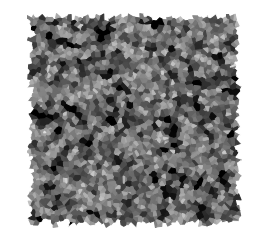

In [21]:
#plot reg vs antireg
# color Voronoi polygons
fig,ax=plt.subplots(1)
patches=[]
cmap=plt.get_cmap('gray_r')
#flatphase=[val for sublist in cphase for val in sublist]
#colors=cmap([x*10 for x in flatphase])
colors=cmap([(x) for x in surfacearea])
#for region in range(len(vor.regions)):
#    if not -1 in vor.regions[region]:
#        pg=Polygon(vor.vertices,closed=True)
#        patches.append(pg)




for i in range(len(vor.point_region)):
    verts=vor.regions[vor.point_region[i]] #indices of vertices forming that region
    if (verts==[]):
        pg=Polygon(np.array([[-1,-1],[-1.1,-1.1]]),closed=True)
        patches.append(pg)
    elif (not -1 in verts):
        vertcoord=list([] for _ in xrange(len(verts))) #coordinates of vertices
        for j in range(len(verts)):
            k=verts[j]
            vertcoord[j]=vor.vertices[k]
        pg=Polygon(vertcoord,closed=True)
        patches.append(pg)
    else:
        pg=Polygon(np.array([[-1,-1],[-1.1,-1.1]]),closed=True)
        patches.append(pg)
    



collection=PatchCollection(patches)
ax.add_collection(collection)
collection.set_color(colors)
        
#plt.fill(*zip(*pg))
ax.set_aspect('equal')
ax.set_xlim([0,36.5])
ax.set_ylim([0,36.5])

plt.axis('off')

#plt.savefig('p29_reg.pdf',format='pdf')
plt.show()